In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cross_decomposition import CCA
from scipy.spatial.distance import pdist, squareform
import numpy as np
import scipy.linalg as linalg

In [2]:
%run utils/mlflow_query.py
%run utils/loading.py

In [3]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"))
#mlflow_helper.query_all_runs()

Initialized with 86 MLFlow runs from pkl


In [4]:
class GCCA:
    def __init__(self):
        pass

    def fit(self, views):
        dims = [view.shape[1] for view in views]
        concat = np.concatenate(views, axis = 1)
        self.mean = concat.mean(axis = 0)
        cov = np.cov(concat.T)

        mask = linalg.block_diag(*[np.ones((dim, dim), bool) for dim in dims])

        eigvals, eigvecs = linalg.eigh(cov * np.invert(mask), cov * mask)
        tol = abs(eigvals.real).max() * len(eigvals) * np.finfo(float).eps

        self.theta = eigvecs.real[:, np.greater(abs(eigvals.real), tol)]
    
    def transform(self, views):
        concat = np.concatenate(views, axis = 1)
        return (concat - self.mean).dot(self.theta)

    def transform_as_list(self, views):
        dims = [view.shape[1] for view in views]
        outputs = []

        slc = slice(0,0)
        for i, dim in enumerate(dims):
            slc = slice(slc.stop, slc.stop + dim)
            outputs.append((views[i] - self.mean[slc]).dot(self.theta[slc]))
        return outputs

In [5]:
def load_vec_dict(run_id, local_mlflow_dir=mlflow_helper.local_mlflow_dir):
    run_vec_path = Path(local_mlflow_dir + run_id + '/artifacts/vecs.tsv')
    run_meta_path = Path(local_mlflow_dir + run_id + '/artifacts/meta.tsv')
    if not run_vec_path.exists() or not run_meta_path.exists():
        return None

    vec_np = np.genfromtxt(fname=run_vec_path, delimiter="\t") # shape: (num_features, embedding_dim)
    meta_df = pd.read_csv(run_meta_path, sep='\t', header=None, names=['name'], dtype=str)
    return {
        meta_df.loc[idx, 'name']:vec_np[idx,:] for idx in range(len(meta_df))
    }

def calculate_correlation(vectors, other_vectors, dims=100, print_diag=False):
    corr_matrix = np.corrcoef(vectors, other_vectors, rowvar=False)
    corr_matrix = corr_matrix[dims:, :dims]
    diag = np.diag(corr_matrix)
    if print_diag: print(diag)
    return np.mean(diag)

def pretty_print_result_dict(cca_correlation_dict):
    for from_corr, to_corr_dict in cca_correlation_dict.items():
        print(from_corr + '\n')
        for to_corr, corr_values in to_corr_dict.items():
            print('\t' + to_corr + '\n\t -> before:' + str(corr_values[0]) + '\n\t -> after:' + str(corr_values[1]) + '\n\t -> fitting score:' + str(corr_values[2]))

def calculate_cca_corr_between(run_id, other_run_id, relevant_run_ids, dims=100):
    if run_id not in relevant_run_ids or other_run_id not in relevant_run_ids:
        return None
    
    run_mlflow_dir = Path(local_mlflow_dir + run_id)
    other_run_mlflow_dir = Path(local_mlflow_dir + other_run_id)
    if not run_mlflow_dir.is_dir() or not other_run_mlflow_dir.is_dir():
        return None

    vec_dict = load_vec_dict(run_id)
    other_vec_dict = load_vec_dict(other_run_id)
    if vec_dict is None or other_vec_dict is None:
        return None

    shared_meta = [
        x for x in vec_dict if x in other_vec_dict and not x.endswith('_hidden') and not x.endswith('_base')
    ]

    vectors = np.array([vec_dict[x] for x in shared_meta])
    other_vectors = np.array([other_vec_dict[x] for x in shared_meta])
    corr_before = calculate_correlation(vectors, other_vectors, dims=300)

    print('Calculating CCA...')
    cca = CCA(n_components=dims, max_iter=5000)
    cca.fit(vectors, other_vectors)
    vectors_t, other_vectors_t = cca.transform(
        vectors, other_vectors
    )

    print('Calculating correlation coefficient...')
    corr_after = calculate_correlation(vectors_t, other_vectors_t, dims=dims, print_diag=True)
    return (corr_before, corr_after, cca.score(vectors, other_vectors))

def calculate_gcca_corr_between(run_id, other_run_id, relevant_run_ids, dims=100, local_mlflow_dir=mlflow_helper.local_mlflow_dir):
    if run_id not in relevant_run_ids or other_run_id not in relevant_run_ids:
        return None
    
    run_mlflow_dir = Path(local_mlflow_dir + run_id)
    other_run_mlflow_dir = Path(local_mlflow_dir + other_run_id)
    if not run_mlflow_dir.is_dir() or not other_run_mlflow_dir.is_dir():
        return None

    vec_dict = load_vec_dict(run_id)
    other_vec_dict = load_vec_dict(other_run_id)
    if vec_dict is None or other_vec_dict is None:
        return None

    shared_meta = [
        x for x in vec_dict if x in other_vec_dict and not x.endswith('_hidden') and not x.endswith('_base')
    ]
    if len(shared_meta) == 0:
        return None

    vectors = np.array([vec_dict[x] for x in shared_meta])
    other_vectors = np.array([other_vec_dict[x] for x in shared_meta])
    corr_before = calculate_correlation(vectors, other_vectors, dims=300)

    #print('Calculating GCCA...')
    gcca = GCCA()
    gcca.fit([vectors, other_vectors])
    transform_l = gcca.transform_as_list((vectors, other_vectors))
    # gcca computes positive and negative correlations (eigenvalues), sorted in ascending order.
    # We are only interested in the positive portion
    vectors_t = transform_l[0][:,dims:]
    other_vectors_t = transform_l[1][:,dims:]

    #print('Calculating correlation coefficient...')
    corr_after = calculate_correlation(vectors_t, other_vectors_t, dims=dims)
    return (corr_before, corr_after, np.nan)

In [6]:
def calculate_all_correlations(runs, relevant_run_ids, correlation_map={}, local_mlflow_dir=mlflow_helper.local_mlflow_dir, dims=300):
    number_correlations = len(relevant_run_ids) * len(relevant_run_ids)
    with tqdm(total=number_correlations, desc='Calculating embedding gcca correlations per run') as pbar:
        for run in runs:
            if not 'data_tags_model_type' in run:
                continue
            run_id = run["info_run_id"]
            if run_id not in relevant_run_ids:
                continue
            suffix = '_{model}_{trainable}{noise}_{run_id}'.format(
                model=run["data_tags_model_type"],
                trainable=run["data_params_ModelConfigbase_feature_embeddings_trainable"],
                noise=(run["data_tags_noise_type"] + '_') 
                    if 'data_tags_noise_type' in run 
                        and not str(run['data_tags_noise_type']).lower() == 'nan' 
                        and not len(str(run['data_tags_noise_type'])) < 1 
                    else '',
                run_id=run["info_run_id"],
            )
            
            for other_run in runs:
                if not 'data_tags_model_type' in other_run:
                    continue
                other_run_id = other_run["info_run_id"]
                if other_run_id not in relevant_run_ids:
                    continue
                other_suffix = '_{model}_{trainable}{noise}_{run_id}'.format(
                    model=other_run["data_tags_model_type"],
                    trainable=other_run["data_params_ModelConfigbase_feature_embeddings_trainable"],
                    noise=(other_run["data_tags_noise_type"] + '_') 
                        if 'data_tags_noise_type' in other_run 
                            and not str(other_run['data_tags_noise_type']).lower() == 'nan' 
                            and not len(str(other_run['data_tags_noise_type'])) < 1 
                        else '',
                    run_id=other_run["info_run_id"],
                )
                if suffix in correlation_map and other_suffix in correlation_map[suffix]: 
                    pbar.update(1)
                    continue
                if other_suffix in correlation_map and suffix in correlation_map[other_suffix]: 
                    if suffix not in correlation_map:
                        correlation_map[suffix] = {}
                    correlation_map[suffix][other_suffix] = correlation_map[other_suffix][suffix]
                    pbar.update(1)
                    continue
                
                correlation = calculate_gcca_corr_between(run_id, other_run_id, relevant_run_ids, dims=dims, local_mlflow_dir=local_mlflow_dir)
                pbar.update(1)
                if correlation is not None:
                    if suffix not in correlation_map:
                        correlation_map[suffix] = {}
                    correlation_map[suffix][other_suffix] = correlation
                    
                
    return correlation_map

In [7]:
def calculate_suffix_mapping(suffixes):
    suffix_mapping = {x:"_".join(x.split("_")[0:len(x.split("_"))-1]).replace("_False", "").replace("_True", "_trainable").replace("gram", "hierarchy").lower() for x in suffixes}
    for suffix in suffix_mapping:
        same_mapped_suffixes = [s for s in suffix_mapping if suffix_mapping[s] == suffix_mapping[suffix]]
        if len(same_mapped_suffixes) > 1:
            for idx in range(len(same_mapped_suffixes)):
                suffix_mapping[same_mapped_suffixes[idx]] = suffix_mapping[same_mapped_suffixes[idx]] + '_' + str(idx)

    return suffix_mapping 

In [9]:
mimic_df = mlflow_helper.huawei_run_df()
runs = [
    x for x in mlflow_helper.run_df.to_dict(orient="index").values()
    if x["info_run_id"] in set(mimic_df["info_run_id"])
]
run_suffixes = {
    x["info_run_id"]:'_{model}_{trainable}{noise}_{run_id}'.format(
        model=x["data_tags_model_type"],
        trainable=x["data_params_ModelConfigbase_feature_embeddings_trainable"],
        noise=(x["data_tags_noise_type"] + '_') 
            if 'data_tags_noise_type' in x 
                and not str(x['data_tags_noise_type']).lower() == 'nan' 
                and not len(str(x['data_tags_noise_type'])) < 1 
            else '',
        run_id=x["info_run_id"],
    )
    for x in runs
    if x["info_run_id"] in set(mimic_df[
        mimic_df["data_tags_model_type"].apply(lambda x: x in ["gram", "simple", "text", "causal2"])
    ]['info_run_id'])
}
correlations = {}

In [10]:
suffix_mapping = calculate_suffix_mapping(run_suffixes.values())
relevant_ids = [x.split('_')[-1] for x in suffix_mapping if int(suffix_mapping[x][-1]) < 2]
relevant_ids

['a8ae6990c12345cda801407c9da4f486',
 'f54a95d96d944a16aca39903a5e0355d',
 '4ac6c90ba3e04d5bb2cc8eaffb6823d3',
 'b6f603c41e8c448b83d96474968b1d8e',
 'efecce66a1484c9dbc514deb95458b67',
 'd033851ca2484ced9dfc485a2ee4b578']

In [11]:
correlations = calculate_all_correlations(runs, set(relevant_ids), correlation_map=correlations, dims=300)
pretty_print_result_dict(correlations)

Calculating embedding gcca correlations per run: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]

_text_False_a8ae6990c12345cda801407c9da4f486

	_text_False_a8ae6990c12345cda801407c9da4f486
	 -> before:1.0
	 -> after:0.9999999999999997
	 -> fitting score:nan
	_gram_False_f54a95d96d944a16aca39903a5e0355d
	 -> before:-0.018783770567094155
	 -> after:0.45348765631566407
	 -> fitting score:nan
	_simple_False_4ac6c90ba3e04d5bb2cc8eaffb6823d3
	 -> before:0.0002414738631178547
	 -> after:0.3948324575314257
	 -> fitting score:nan
	_text_False_b6f603c41e8c448b83d96474968b1d8e
	 -> before:-0.014951597677655299
	 -> after:0.6095860028947108
	 -> fitting score:nan
	_gram_False_efecce66a1484c9dbc514deb95458b67
	 -> before:-0.0016405660568571186
	 -> after:0.5137175372947741
	 -> fitting score:nan
	_simple_False_d033851ca2484ced9dfc485a2ee4b578
	 -> before:0.0014253614936295227
	 -> after:0.39510197450340867
	 -> fitting score:nan
_gram_False_f54a95d96d944a16aca39903a5e0355d

	_text_False_a8ae6990c12345cda801407c9da4f486
	 -> before:-0.018783770567094155
	 -> after:0.45348765631566407
	 -> fitti

In [12]:
suffix_mapping = calculate_suffix_mapping(correlations.keys())
suffix_mapping 

{'_text_False_a8ae6990c12345cda801407c9da4f486': '_text_0',
 '_gram_False_f54a95d96d944a16aca39903a5e0355d': '_hierarchy_0',
 '_simple_False_4ac6c90ba3e04d5bb2cc8eaffb6823d3': '_simple_0',
 '_text_False_b6f603c41e8c448b83d96474968b1d8e': '_text_1',
 '_gram_False_efecce66a1484c9dbc514deb95458b67': '_hierarchy_1',
 '_simple_False_d033851ca2484ced9dfc485a2ee4b578': '_simple_1'}

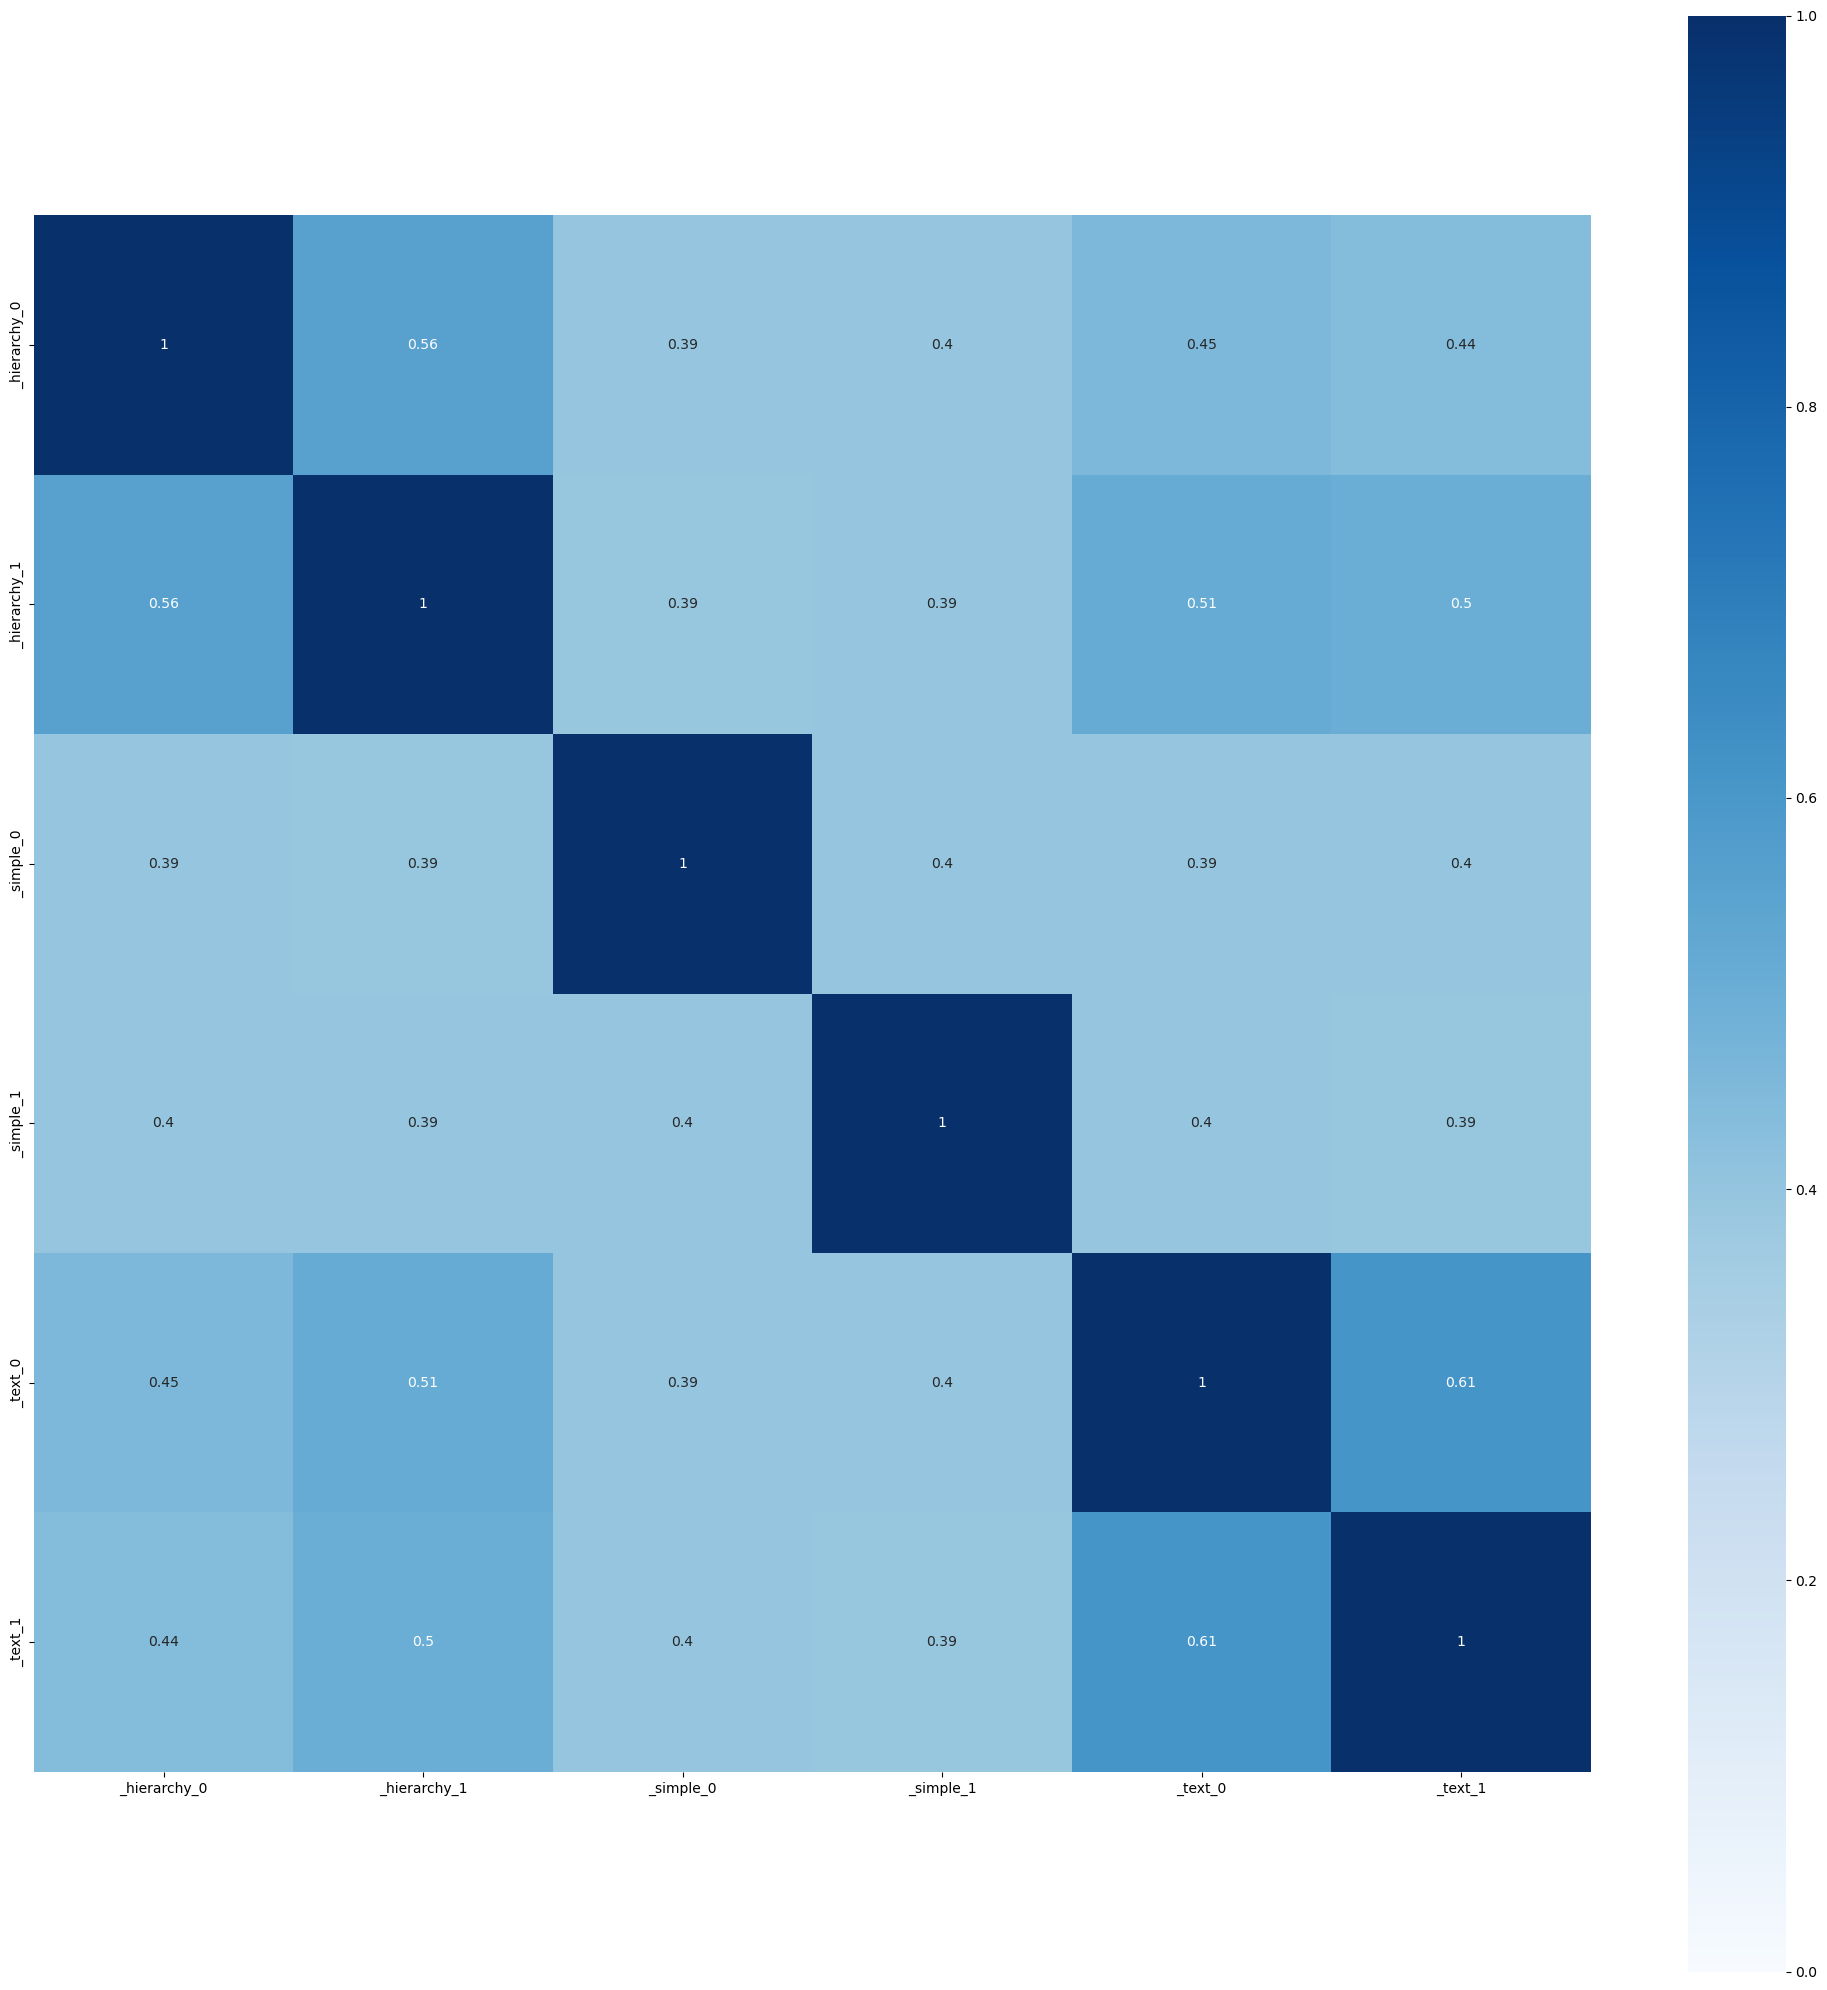

In [13]:
corr_df = pd.DataFrame.from_dict({
    suffix_mapping[k_from]:{
        suffix_mapping[k_to]:v[1] for k_to,v in vs.items()
    } for k_from,vs in correlations.items()
}, orient='index').sort_index(axis=0).sort_index(axis=1)

plt.figure(figsize=(20,20))
ax = sns.heatmap(
    data=corr_df, 
    vmin=0, 
    vmax=1, 
    cmap='Blues', 
    square=True, 
    annot=True)
ax.figure.tight_layout()
plt.show()

In [14]:
trainable = "_trainable_"

order = [
    "_simple" + trainable + str(i) for i in range(2)
] + [
    "_hierarchy" + trainable + str(i) for i in range(2)
] + [
    "_causal" + trainable + str(i) for i in range(2)
] + [
    "_text" + trainable + str(i) for i in range(2)
]
corr_df = pd.DataFrame.from_dict({
    suffix_mapping[k_from]:{
        suffix_mapping[k_to]:v[1] for k_to,v in vs.items() if "trainable" in suffix_mapping[k_to]
    } for k_from,vs in correlations.items() if "trainable" in suffix_mapping[k_from]
}, orient='index').sort_index(axis=0).sort_index(axis=1)
corr_df.index = pd.CategoricalIndex(corr_df.index, categories=order)
corr_df = corr_df.sort_index()[order]

plt.figure()#figsize=(20,20))
ax = sns.heatmap(
    data=corr_df, 
    vmin=0, 
    vmax=1, 
    cmap='Blues', 
    square=True, 
    annot=True,
    linecolor='white',
    linewidth=1,
    cbar_kws={'label': 'Embedding Space Similarity'})
ax.figure.tight_layout()
#plt.savefig("embssim_trainable_all.png", dpi=100)
plt.show()

KeyError: "None of [Index(['_simple_trainable_0', '_simple_trainable_1', '_hierarchy_trainable_0',\n       '_hierarchy_trainable_1', '_causal_trainable_0', '_causal_trainable_1',\n       '_text_trainable_0', '_text_trainable_1'],\n      dtype='object')] are in the [columns]"

In [ ]:
model_type = "_causal"

order = [
    model_type + "_" + str(i) for i in range(2)
] + [
    model_type + "_trainable_" + str(i) for i in range(2)
] #+ [
  #  "_simple_trainable_" + str(i) for i in range(2)
#]
corr_df = pd.DataFrame.from_dict({
    suffix_mapping[k_from]:{
        suffix_mapping[k_to]:v[1] for k_to,v in vs.items() if model_type in suffix_mapping[k_to] #or "_simple_trainable_" in suffix_mapping[k_to]
    } for k_from,vs in correlations.items() if model_type in suffix_mapping[k_from] #or "_simple_trainable_" in suffix_mapping[k_from]
}, orient='index').sort_index(axis=0).sort_index(axis=1)
corr_df.index = pd.CategoricalIndex(corr_df.index, categories=order)
corr_df = corr_df.sort_index()[order]

plt.figure()#figsize=(20,20))
ax = sns.heatmap(
    data=corr_df, 
    vmin=0, 
    vmax=1, 
    cmap='Blues', 
    square=True, 
    annot=True,
    linecolor='white',
    linewidth=1,
    cbar_kws={'label': 'Embedding Space Similarity'})
ax.figure.tight_layout()
plt.savefig("embssim" + model_type + ".png", dpi=100)
plt.show()

# Correlation of Embedding Distances

In [15]:
def calculate_embedding_distances(vec_np, meta_df):
    distances = squareform(pdist(vec_np)) 
    all_words = [
        str(row['name'])
        for _,row in sorted(meta_df.iterrows(), key=lambda x: x[0])
    ]
    relevant_words = set([word for word in all_words if not (word.endswith('_hidden') or word.endswith('_base'))])
    return pd.DataFrame(distances, columns=all_words, index=all_words) \
        .drop(labels=[x for x in all_words if x not in relevant_words], axis=0) \
        .drop(labels=[x for x in all_words if x not in relevant_words], axis=1)

In [16]:
local_mlflow_dir = '../mlruns/' + experiment.experiment_id + '/'
distances_df = None
suffixes = []

for run in tqdm(runs, desc='Calculating embedding distances per run'):
    run_id = run.info.run_id
    if run_id not in set(relevant_run_df['info_run_id']):
        print('Ignoring run {}'.format(run_id))
        continue

    run_mlflow_dir = Path(local_mlflow_dir + run_id)
    if not run_mlflow_dir.is_dir():
        print('Run {} is not in local MlFlow dir'.format(run_id))
        continue

    run_vec_path = Path(local_mlflow_dir + run_id + '/artifacts/vecs.tsv')
    run_meta_path = Path(local_mlflow_dir + run_id + '/artifacts/meta.tsv')
    if not run_vec_path.exists() or not run_meta_path.exists():
        print('No vecs.tsv file for run {} in local MlFlow dir'.format(run_id))
        continue

    vec_np = np.genfromtxt(fname=run_vec_path, delimiter="\t") # shape: (num_features, embedding_dim)
    meta_df = pd.read_csv(run_meta_path, sep='\t', header=None, names=['name'])

    suffix = '_' + run.data.tags['model_type'] + '_' + run.data.params['ModelConfigbase_feature_embeddings_trainable'] + '_' + run_id
    distance_df = calculate_embedding_distances(vec_np, meta_df)
    if distances_df is None:
        distances_df = distance_df.copy()
        print('Initialized distances df with length {}'.format(len(distances_df)))
    
    distances_df = pd.merge(distances_df, distance_df, left_index=True, right_index=True, how='inner', suffixes=('',suffix))
    print('Merged prediction output df, new length {} (dropna: {}, columns: {})'.format(
        len(distances_df), len(distances_df.dropna()), len(distances_df.columns)
    ))
    suffixes.append(suffix)

distances_df.head()

NameError: name 'experiment' is not defined

In [ ]:
suffix_mapping = {x:"_".join(x.split("_")[0:len(x.split("_"))-1]) for x in suffixes}
for suffix in suffix_mapping:
    same_mapped_suffixes = [s for s in suffix_mapping if suffix_mapping[s] == suffix_mapping[suffix]]
    if len(same_mapped_suffixes) > 1:
        for idx in range(len(same_mapped_suffixes)):
            suffix_mapping[same_mapped_suffixes[idx]] = suffix_mapping[same_mapped_suffixes[idx]] + '_' + str(idx)

suffix_mapping 

In [ ]:
distances_df_renamed = distances_df.rename(columns={
    pre+suf:pre+suffix_mapping[suf] for suf in suffix_mapping for pre in set(distances_df.index)
})
print(len(distances_df.columns))
print(len(distances_df_renamed.columns))
distances_df_renamed.head()

In [ ]:
all_suffixes = list(set(suffix_mapping.values()))
all_labels = set(distances_df_renamed.index)
correlation_summary_dfs = []
for label in tqdm(all_labels, desc="Adding correlation summaries per label"):
    relevant_columns = [x for x in distances_df_renamed.columns if x.startswith(label)]
    for method in ["spearman", "pearson", "kendall"]:
        correlation_df = distances_df_renamed[relevant_columns].corr(method=method)
        for s1_idx in range(len(all_suffixes)):
            s1 = all_suffixes[s1_idx]
            for s2_idx in range(s1_idx+1, len(all_suffixes)):
                s2 = all_suffixes[s2_idx]
                correlation_summary_dfs.append(
                    pd.DataFrame.from_dict({
                        's1': [s1, s2], 
                        's2': [s2, s1], 
                        's1<>s2': ["{}<>{}".format(s1, s2),"{}<>{}".format(s2, s1)], 
                        'label': [label, label], 
                        'correlation': [correlation_df.loc[label+s1, label+s2],correlation_df.loc[label+s2, label+s1]],
                        'method': [method, method],
                    })
                )

correlation_summary_df = pd.concat(correlation_summary_dfs, ignore_index=True)
correlation_summary_df.head()

In [ ]:
#fig = px.box(correlation_summary_df, facet_col="s1", facet_row="s2", x="method", y="correlation", hover_data=["label"]) 
#fig.show()

In [ ]:
#sns.catplot(data=correlation_summary_df, x="method", y="correlation", row="s1", col="s2", kind='box', height=5, aspect=1)
#plt.show()

In [ ]:
grouped_df = correlation_summary_df.groupby(by=["method", "s1", "s2"], as_index=False).mean()
grouped_df = grouped_df[grouped_df["method"] == "pearson"].pivot(index='s1', columns='s2', values='correlation').fillna(1)

plt.figure(figsize=(20,20))
#ax = sns.heatmap(data=grouped_df, vmin=-1, vmax=1, center=0, cmap='Blues', square=True)
ax = sns.heatmap(data=grouped_df, vmax=1, cmap='Blues', square=True, annot=True)
ax.figure.tight_layout()
plt.show()